In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation,Dropout
from keras.models import Model,load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.engine.topology import Layer
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
%tensorflow_version 2.x

Using TensorFlow backend.
UsageError: Line magic function `%tensorflow_version` not found.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, Activation,Dropout
from keras.models import Model,load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.engine.topology import Layer
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import load_files
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import itertools
%matplotlib inline

In [3]:
train_dir = '/Users/anas/Desktop/waste-classification-data/DATASET/TRAIN'
test_dir = '/Users/anas/Desktop/waste-classification-data/DATASET/TEST'

def load_dataset(path):
    data = load_files(path) #load all files from the path
    files = np.array(data['filenames']) #get the file  
    targets = np.array(data['target'])#get the the classification labels as integer index
    target_labels = np.array(data['target_names'])#get the the classification labels 
    return files,targets,target_labels
    
x_train, y_train,target_labels = load_dataset(train_dir)
x_test, y_test,_ = load_dataset(test_dir)

print('Training set size : ' , x_train.shape[0])
print('Testing set size : ', x_test.shape[0])

Training set size :  22564
Testing set size :  2513


In [4]:
x_train,x_validate,y_train,y_validate = train_test_split(x_train,y_train,test_size = 0.2,random_state = 1)


In [5]:
print ("x_train shape: " + str(x_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("x_validate shape: " + str(x_validate.shape))
print ("y_validate shape: " + str(y_validate.shape))
print ("x_test shape: " + str(x_test.shape))
print ("y_test shape: " + str(y_test.shape))

x_train shape: (18051,)
y_train shape: (18051,)
x_validate shape: (4513,)
y_validate shape: (4513,)
x_test shape: (2513,)
y_test shape: (2513,)


In [6]:
def convert_image_to_array(files):
    width, height, channels = 100, 100, 3
    images_as_array = np.empty((files.shape[0], width, height, channels), dtype=np.uint8) #define train and test data shape
    for idx,file in enumerate(files):
        img = cv2.imread(file) 
        res = cv2.resize(img, dsize=(width, height), interpolation=cv2.INTER_CUBIC) #As images have different size, resizing all images to have same shape of image array
        images_as_array[idx] = res
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_valid = np.array(convert_image_to_array(x_validate))
print('Validation set shape : ',x_valid.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Training set shape :  (18051, 100, 100, 3)
Validation set shape :  (4513, 100, 100, 3)
Test set shape :  (2513, 100, 100, 3)


In [7]:
x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)
y_validate = y_validate.reshape(y_validate.shape[0],1)

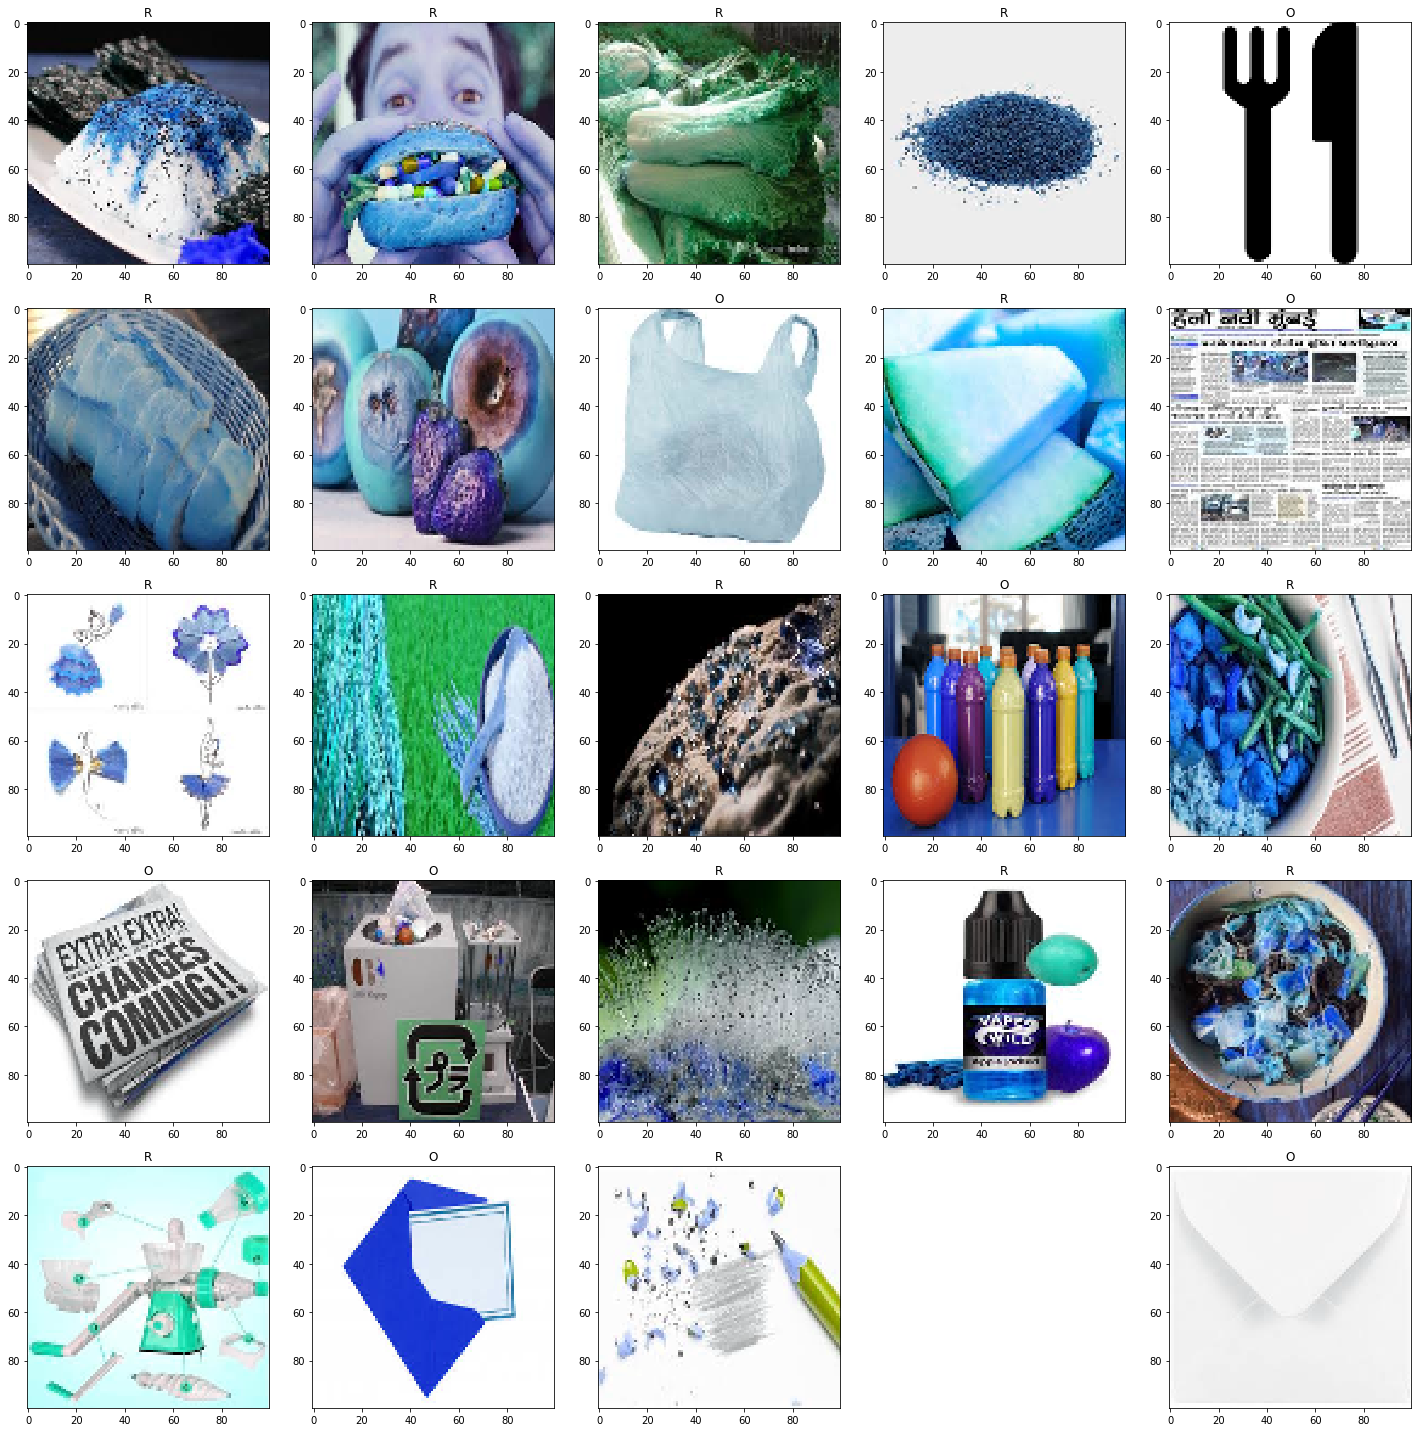

In [8]:
plt.figure(figsize=(20,20))
classes = ['R','O']
for i in range(1,26):
    index = np.random.randint(x_train.shape[0])
    plt.subplot(5, 5, i)
    plt.imshow(np.squeeze(x_train[index]), cmap='cool')
    plt.title(classes[int(y_train[index])])
    plt.tight_layout()
plt.show()

In [9]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images
datagen.fit(x_train)

In [10]:
model = Sequential()
model.add(Conv2D(32,kernel_size=(3, 3),kernel_initializer='he_normal',activation='relu',input_shape=(100,100,3),name = 'conv0'))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu', name = 'conv1'))
model.add(BatchNormalization(name='bn0'))
model.add(MaxPooling2D(pool_size=(2, 2),name = 'maxpool0'))
model.add(Dropout(0.2,name='dropout0'))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',name = 'conv2'))
model.add(Conv2D(64, kernel_size=(3, 3),activation='relu', name = 'conv3'))
model.add(BatchNormalization(name='bn1'))
model.add(MaxPooling2D(pool_size=(2, 2),name = 'maxpool1'))
model.add(Dropout(0.2,name='dropout1'))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',name = 'conv4'))
model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',name = 'conv5'))
model.add(BatchNormalization(name='bn2'))
model.add(MaxPooling2D(pool_size=(2, 2),name = 'maxpool2'))
model.add(Dropout(0.3,name='dropout2'))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',name = 'conv6'))
model.add(Conv2D(256, kernel_size=(3, 3),activation='relu',name = 'conv7'))
model.add(BatchNormalization(name='bn3'))
model.add(MaxPooling2D(pool_size=(2, 2),name = 'maxpool3'))
model.add(Dropout(0.3,name='dropout3'))

model.add(Flatten(name='fc'))
model.add(Dense(512, activation='relu',name = 'Dense0'))
model.add(Dense(256, activation='relu',name = 'Dense1'))
model.add(Dense(128, activation='relu',name = 'Dense2'))
model.add(Dropout(0.3,name='dropout4'))
model.add(Dense(2, activation='softmax',name = 'Dense3'))

model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [11]:
checkpoint = ModelCheckpoint(filepath = 'cnn.hdf5', verbose = 1, save_best_only = True)

In [12]:
earlystop = EarlyStopping(monitor = 'val_loss', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 15, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped


In [13]:
ReduceLR = ReduceLROnPlateau(patience=3, verbose=1)

In [14]:
callbacks = [earlystop, checkpoint, ReduceLR]

In [15]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size= 32), epochs = 60, verbose=1,callbacks = callbacks,validation_data=(x_valid,y_validate))


Epoch 1/60
565/565 [==============================] - 830s 1s/step - loss: 0.4854 - accuracy: 0.7862 - val_loss: 0.4444 - val_accuracy: 0.8101

Epoch 00001: val_loss improved from inf to 0.44435, saving model to cnn.hdf5
Epoch 2/60
565/565 [==============================] - 784s 1s/step - loss: 0.4100 - accuracy: 0.8287 - val_loss: 0.6455 - val_accuracy: 0.6769

Epoch 00002: val_loss did not improve from 0.44435
Epoch 3/60
565/565 [==============================] - 783s 1s/step - loss: 0.3960 - accuracy: 0.8385 - val_loss: 0.6685 - val_accuracy: 0.7181

Epoch 00003: val_loss did not improve from 0.44435
Epoch 4/60
565/565 [==============================] - 777s 1s/step - loss: 0.3708 - accuracy: 0.8485 - val_loss: 0.7229 - val_accuracy: 0.7055

Epoch 00004: val_loss did not improve from 0.44435

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/60
565/565 [==============================] - 778s 1s/step - loss: 0.3228 - accuracy: 0.8691 - val_loss:

565/565 [==============================] - 833s 1s/step - loss: 0.2697 - accuracy: 0.8934 - val_loss: 0.2530 - val_accuracy: 0.9029
Restoring model weights from the end of the best epoch

Epoch 00038: val_loss did not improve from 0.25236

Epoch 00038: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.
Epoch 00038: early stopping


In [16]:
import pickle

pickle_out = open("Trained_cnn_history.pickle","wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

In [17]:
pickle_in = open("Trained_cnn_history.pickle","rb")
saved_history = pickle.load(pickle_in)
print(saved_history)

{'val_loss': [0.4443526969454504, 0.645450414362911, 0.6684819826552487, 0.722874940181291, 0.2761601613858851, 0.27482726878149993, 0.2725529836343406, 0.26095167723720214, 0.2739060744511138, 0.2619834392810925, 0.26334136022544147, 0.25508790463952064, 0.25448214739260616, 0.2535358547424345, 0.25404683536415107, 0.2550375810507565, 0.2553394269394225, 0.2543936424838937, 0.2531372578982813, 0.25443960834478635, 0.2532812132457395, 0.253499748125844, 0.2523552753284463, 0.252801994282881, 0.25246240319902896, 0.25288348048248527, 0.25304765892998227, 0.2539588047468854, 0.25381186974139747, 0.25357247640672015, 0.2528855646696291, 0.25314159569599404, 0.25262510955417083, 0.2532653077226937, 0.2534620968045891, 0.25237421210217165, 0.25370276060193503, 0.25299389792617377], 'val_accuracy': [0.8101041316986084, 0.6769332885742188, 0.7181475758552551, 0.7055174112319946, 0.887214720249176, 0.889208972454071, 0.8962996006011963, 0.8965211510658264, 0.8878794312477112, 0.897629082202911

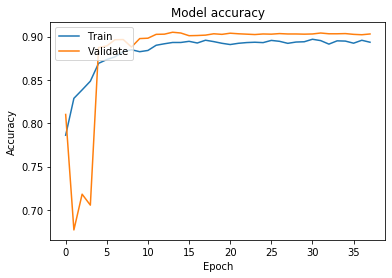

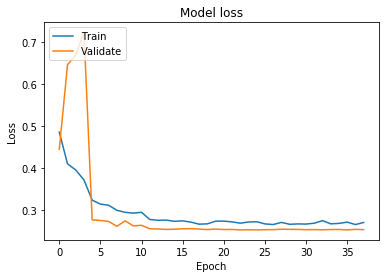

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

In [19]:
model = load_model('cnn.hdf5')
model.load_weights('cnn.hdf5')

In [20]:
score = model.evaluate(x_test,y_test,verbose=0)
print('Test Loss :',score[0])
print('Test Accuracy :',score[1])

Test Loss : 0.24411449805228205
Test Accuracy : 0.9068841934204102


In [21]:
#get the predictions for the test data
predicted_classes = model.predict_classes(x_test)

Text(0.5, 59.00999999999999, 'Predicted label')

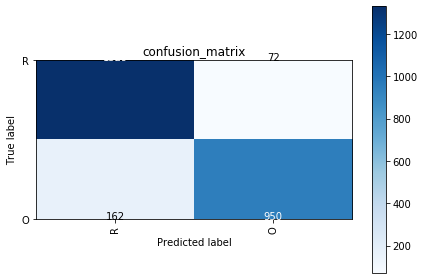

In [27]:
confusion_mtx = confusion_matrix(y_test, predicted_classes) 

plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['R','O'], rotation=90)
plt.yticks(tick_marks, ['R','O'])
#Following is to mention the predicated numbers in the plot and highligh the numbers the most predicted number for particular label
thresh = confusion_mtx.max() / 2.
for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, confusion_mtx[i, j],
    horizontalalignment="center",
    color="white" if confusion_mtx[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Text(0.5, 18.125, 'Predicted label')

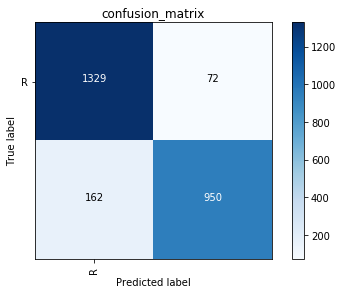

In [46]:
confusion_mtx = confusion_matrix(y_test, predicted_classes) 

plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('confusion_matrix')
plt.colorbar()
tick_marks = np.arange(1)
plt.xticks(tick_marks, ['R','O'],rotation=90)
plt.yticks(tick_marks, ['R','O'])
thresh = confusion_mtx.max() / 2.
for i, j in itertools.product(range(confusion_mtx.shape[0]), range(confusion_mtx.shape[1])):
    plt.text(j, i, confusion_mtx[i, j],
    horizontalalignment="center",
    color="white" if confusion_mtx[i, j] > thresh else "black")
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')